<a href="https://colab.research.google.com/github/dhineshkv/beam-strength/blob/main/beam_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow scikit-learn matplotlib joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

In [3]:
from google.colab import files
uploaded = files.upload()

Saving rc_beam_bearing_capacity_dataset.csv to rc_beam_bearing_capacity_dataset.csv


In [4]:
df = pd.read_csv("rc_beam_bearing_capacity_dataset.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (3234, 10)


,Beam_Length_mm,Beam_Width_mm,Beam_Height_mm,Concrete_Grade_MPa,Longitudinal_Reinforcement_Ratio_percent,Stirrup_Spacing_mm,Stirrup_Diameter_mm,Steel_Yield_Strength_MPa,Concrete_Compressive_Strength_MPa,Bearing_Capacity_kN
0,3061.810178,258.654930,583.508248,40,2.420631,200,10,500,40,5409.692168
1,3926.071460,235.130506,541.587820,40,1.904363,150,12,550,40,4463.967480
2,3597.990913,232.933088,514.487478,35,1.868609,150,12,550,35,3959.578646
3,3397.987726,343.979420,555.974095,35,1.347852,150,10,500,35,4700.863286
4,2734.027961,292.445073,511.879949,25,1.070047,150,8,550,25,2926.786455


In [5]:
X = df.drop(columns=['Bearing_Capacity_kN']).values
y = df['Bearing_Capacity_kN'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [8]:
def build_model(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.15)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='linear')(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model(X_train_s.shape[1])

In [9]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6)

history = model.fit(
    X_train_s, y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=32,
    callbacks=[es, rlr],
    verbose=1
)

Epoch 1/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 15500804.0000 - mae: 3864.4602 - val_loss: 15493281.0000 - val_mae: 3869.1633 - learning_rate: 0.0010
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15549017.0000 - mae: 3872.1707 - val_loss: 15277486.0000 - val_mae: 3842.6453 - learning_rate: 0.0010
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14821121.0000 - mae: 3780.6118 - val_loss: 14672728.0000 - val_mae: 3767.0039 - learning_rate: 0.0010
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14397397.0000 - mae: 3724.4534 - val_loss: 13597276.0000 - val_mae: 3627.3042 - learning_rate: 0.0010
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13189992.0000 - mae: 3571.0012 - val_loss: 12098057.0000 - val_mae: 3420.2117 - learning_rate: 0.0010
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11678674.0000 - mae: 3356.9880 - val_loss: 10293342.0000 - val_mae: 3146.1985 - learning_rate: 0.0010
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━

In [10]:
y_pred = model.predict(X_test_s).ravel()
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MAE:", mae)
print("Test R²:", r2)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test MAE: 60.44215833232003
Test R²: 0.9867055232572517


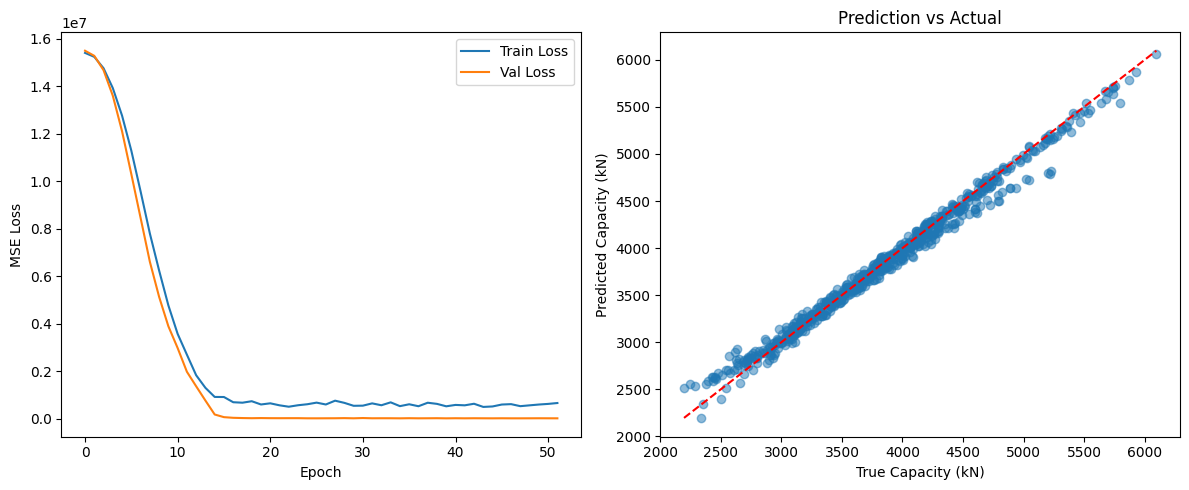

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Capacity (kN)")
plt.ylabel("Predicted Capacity (kN)")
plt.title("Prediction vs Actual")

plt.tight_layout()
plt.show()


In [12]:
model.save("beam_fnn_model.keras")   # <-- fixed
joblib.dump(scaler, "scaler.save")

print("✅ Model and scaler saved!")

✅ Model and scaler saved!


In [13]:
model.save("beam_fnn_model.keras")   # model
joblib.dump(scaler, "scaler.save")   # scaler


['scaler.save']

In [14]:
import tensorflow as tf
import joblib

# Load model (Keras format)
model = tf.keras.models.load_model("beam_fnn_model.keras")

# Load scaler
scaler = joblib.load("scaler.save")

print("✅ Model and Scaler Loaded Successfully!")


✅ Model and Scaler Loaded Successfully!


In [15]:
sample = X_test[:5]
sample_scaled = scaler.transform(sample)
predictions = model.predict(sample_scaled)

print("Predictions:", predictions.ravel())
print("Actual:", y_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predictions: [4405.4756 3891.9165 2806.8887 4380.3    4548.254 ]
Actual: [4328.60822065 3845.51341463 2898.14573593 4596.11985649 4564.5000829 ]


In [16]:
import numpy as np

# Suppose your model expects 9 features
EXPECTED_FEATURES = 9

# Default values for missing features (can be 0 or column means)
DEFAULT_VALUES = [0] * EXPECTED_FEATURES  # replace with actual means if available

def predict_capacity(features):
    """
    Predict bearing capacity safely even if some features are missing.

    features: list or array of input features (can be < EXPECTED_FEATURES)
    """
    # Fill missing features
    features_filled = list(features)  # copy input
    if len(features_filled) < EXPECTED_FEATURES:
        features_filled += DEFAULT_VALUES[len(features_filled):]

    # Convert to 2D array for scaler
    features_array = np.array([features_filled])

    # Scale and predict
    features_scaled = scaler.transform(features_array)
    return model.predict(features_scaled)[0]

# Example
new_beam = [200, 300, 25, 415]  # only 4 features
print("Predicted Bearing Capacity:", predict_capacity(new_beam))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Predicted Bearing Capacity: [15302.6045]


In [17]:
# Load model (Keras format)
import tensorflow as tf
import joblib

model = tf.keras.models.load_model("beam_fnn_model.keras")

# Load scaler
scaler = joblib.load("scaler.save")

In [18]:
def predict_capacity(features):
    features_scaled = scaler.transform([features])
    pred = model.predict(features_scaled)[0][0]
    return pred


In [19]:
import gradio as gr
import numpy as np

# Your existing function to predict capacity
# Make sure it handles scaling and uses the trained model
# Example:
# def predict_capacity(features):
#     features_scaled = scaler.transform([features])
#     return model.predict(features_scaled)[0][0]

def beam_predict(length, width, height, conc_grade, long_ratio,
                 stirrup_spacing, stirrup_diameter, steel_yield, conc_strength):
    features = [length, width, height, conc_grade, long_ratio,
                stirrup_spacing, stirrup_diameter, steel_yield, conc_strength]
    capacity = predict_capacity(features)
    return f"Predicted Maximum Bearing Capacity: {round(capacity,2)} kN"

# Create Gradio interface with sliders
demo = gr.Interface(
    fn=beam_predict,
    inputs=[
        gr.Slider(500, 3000, step=10, label="Beam Length (mm)"),
        gr.Slider(100, 1000, step=10, label="Beam Width (mm)"),
        gr.Slider(100, 1000, step=10, label="Beam Height (mm)"),
        gr.Slider(10, 80, step=1, label="Concrete Grade (MPa)"),
        gr.Slider(0.5, 5.0, step=0.1, label="Longitudinal Reinforcement Ratio (%)"),
        gr.Slider(50, 400, step=5, label="Stirrup Spacing (mm)"),
        gr.Slider(6, 32, step=1, label="Stirrup Diameter (mm)"),
        gr.Slider(250, 600, step=5, label="Steel Yield Strength (MPa)"),
        gr.Slider(10, 80, step=1, label="Concrete Compressive Strength (MPa)")
    ],
    outputs="text",
    title="Beam Bearing Capacity Calculator",
    description="Input the beam and material parameters to predict the maximum bearing capacity."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3b2b1b03969cb400a9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
